In [1]:
import pandas as pd
dataset = pd.read_csv('02-14-2018.csv')

In [2]:
data  = dataset

In [3]:
data = data.dropna()
# data.shape

In [4]:
# Limit the number of categories for columns with too many unique values
for col in data.select_dtypes(include=['object']).columns:
    if data[col].nunique() > 500:  
        top_categories = data[col].value_counts().index[179200:179600]  # Keeping top 100 categories
        data[col] = data[col].where(data[col].isin(top_categories), other='Other')

C:\Users\sanam\AppData\Local\Temp\ipykernel_23580\227755452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].where(data[col].isin(top_categories), other='Other')


In [5]:
data = pd.get_dummies(data, drop_first=True)

In [6]:
correlation_matrix = data.corr()

In [7]:
print(correlation_matrix.columns)

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [8]:
correlation_ftp = correlation_matrix['Label_FTP-BruteForce'].drop('Label_FTP-BruteForce')
correlation_ssh = correlation_matrix['Label_SSH-Bruteforce'].drop('Label_SSH-Bruteforce')

threshold = 0.05

low_corr_ftp = correlation_ftp[abs(correlation_ftp) < threshold].index
low_corr_ssh = correlation_ssh[abs(correlation_ssh) < threshold].index

low_correlation_columns = low_corr_ftp.intersection(low_corr_ssh)

data_cleaned = data.drop(low_correlation_columns, axis=1)
# dropped columns w low corr

##### data_cleaned

In [9]:
# just checking

In [10]:
ftp_true_count = data_cleaned['Label_FTP-BruteForce'].sum()
ssh_true_count = data_cleaned['Label_SSH-Bruteforce'].sum()

In [11]:
both_false_count = ((~data_cleaned['Label_FTP-BruteForce']) & 
                    (~data_cleaned['Label_SSH-Bruteforce'])).sum()

In [12]:
both_false_count

665355

In [13]:
print(f"Number of True values in FTP BruteForce: {ftp_true_count}")
print(f"Number of True values in SSH BruteForce: {ssh_true_count}")

Number of True values in FTP BruteForce: 193354
Number of True values in SSH BruteForce: 187589


([<matplotlib.patches.Wedge at 0x227341b3250>,
 [Text(0.919770764582218, 0.6033421422541627, 'FTP Brute Force (True)'),
  Text(-0.16827023239926434, 1.0870534158394876, 'SSH Brute Force (True)'),
  Text(-0.4555409498076455, -1.0012404521633893, 'Both False')])

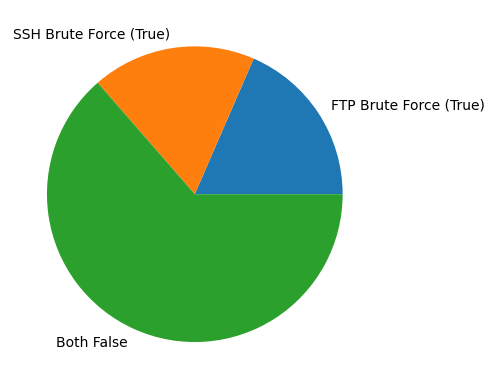

In [14]:
import matplotlib.pyplot as plt
counts = [ftp_true_count, ssh_true_count, both_false_count]
labels = ['FTP Brute Force (True)', 'SSH Brute Force (True)', 'Both False']
plt.pie(counts, labels=labels)



In [15]:
# biased data
# making vae
# Data Balance: A VAE can generate synthetic data points for underrepresented classes (FTP True and SSH True), creating a more balanced dataset.
# Preserving Important Patterns: Simply dropping benign data might remove useful information, whereas VAEs allow the model to learn complex patterns in the minority classes.
# Controlled Data Augmentation: VAEs provide a way to generate realistic samples based on the learned latent representation, making the generated data more consistent with real-world scenarios.

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report


In [17]:
data = data_cleaned

In [18]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
data.fillna(data.mean(), inplace=True)


In [23]:
features = data.drop(['Label_FTP-BruteForce', 'Label_SSH-Bruteforce'], axis=1)
labels = data[['Label_FTP-BruteForce', 'Label_SSH-Bruteforce']]


In [24]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [25]:
# Train on benign data only (both labels are False)
benign_data = features_scaled[(labels['Label_FTP-BruteForce'] == False) & 
                              (labels['Label_SSH-Bruteforce'] == False)]



In [26]:
# Split benign data into training and validation sets
X_train, X_val = train_test_split(benign_data, test_size=0.2, random_state=42)


In [27]:
# 2. Build the Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 16  # Size of the encoding layer

In [28]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)


In [29]:
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [30]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_val, X_val),
                shuffle=True)


Epoch 1/50

16634/16634 [==============================] - 41s 2ms/step - loss: 0.1166 - val_loss: 0.0958
Epoch 2/50
16634/16634 [==============================] - 37s 2ms/step - loss: 0.0762 - val_loss: 0.0715
Epoch 3/50
16634/16634 [==============================] - 37s 2ms/step - loss: 0.0781 - val_loss: 0.0699
Epoch 4/50
16634/16634 [==============================] - 35s 2ms/step - loss: 0.0752 - val_loss: 0.0743
Epoch 5/50
16634/16634 [==============================] - 34s 2ms/step - loss: 0.0741 - val_loss: 0.0695
Epoch 6/50
16634/16634 [==============================] - 33s 2ms/step - loss: 0.0734 - val_loss: 0.0718
Epoch 7/50
16634/16634 [==============================] - 35s 2ms/step - loss: 0.0739 - val_loss: 0.0760
Epoch 8/50
16634/16634 [==============================] - 36s 2ms/step - loss: 0.0748 - val_loss: 0.0695
Epoch 9/50
16634/16634 [==============================] - 34s 2ms/step - loss: 0.0758 - val_loss: 0.0724
Epoch 10/50
16634/16634 [=============================

In [34]:
# 4. Calculate Reconstruction Error for the Full Dataset


In [33]:
reconstructions = autoencoder.predict(features_scaled)
reconstruction_errors = np.mean(np.square(features_scaled - reconstructions), axis=1)


32697/32697 [==============================] - 44s 1ms/step


In [35]:
# 5. Set Threshold for Anomalies
threshold = np.percentile(reconstruction_errors, 95)  # 95th percentile


In [36]:
# Classify anomalies
anomalies = reconstruction_errors > threshold


In [38]:
attack_type = np.where((labels['Label_FTP-BruteForce'] == True), 'FTP Brute Force',
                       np.where((labels['Label_SSH-Bruteforce'] == True), 'SSH Brute Force', 'Benign'))



In [39]:
# Evaluate the Model
print(confusion_matrix(attack_type, np.where(anomalies, 'Attack', 'Benign')))
print(classification_report(attack_type, np.where(anomalies, 'Attack', 'Benign')))


[[     0      0      0      0]
 [  3838 661517      0      0]
 [     0 193354      0      0]
 [     2 187587      0      0]]


C:\Users\sanam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                 precision    recall  f1-score   support

         Attack       0.00      0.00      0.00         0
         Benign       0.63      0.99      0.77    665355
FTP Brute Force       0.00      0.00      0.00    193354
SSH Brute Force       0.00      0.00      0.00    187589

       accuracy                           0.63   1046298
      macro avg       0.16      0.25      0.19   1046298
   weighted avg       0.40      0.63      0.49   1046298



C:\Users\sanam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import confusion_matrix, classification_report


In [41]:
binary_labels = np.where((labels['Label_FTP-BruteForce'] == True) | 
                         (labels['Label_SSH-Bruteforce'] == True), 'Attack', 'Benign')


In [42]:
# Evaluate the model with binary labels
print("Confusion Matrix:")
print(confusion_matrix(binary_labels, np.where(anomalies, 'Attack', 'Benign')))


Confusion Matrix:
[[     2 380941]
 [  3838 661517]]


In [43]:
print("\nClassification Report:")
print(classification_report(binary_labels, np.where(anomalies, 'Attack', 'Benign')))


Classification Report:
              precision    recall  f1-score   support

      Attack       0.00      0.00      0.00    380943
      Benign       0.63      0.99      0.77    665355

    accuracy                           0.63   1046298
   macro avg       0.32      0.50      0.39   1046298
weighted avg       0.40      0.63      0.49   1046298



In [50]:
# above was without vae 

In [21]:
# trying to increase attacks but still train on beningn 
df = data

In [22]:
benign_data = df[df['Label'] == 'Benign'].drop(columns=['Label'])
attack_data = df[df['Label'] != 'Benign'].drop(columns=['Label'])

# Normalize the dataset
scaler = MinMaxScaler()
benign_data_scaled = scaler.fit_transform(benign_data)
attack_data_scaled = scaler.transform(attack_data)  # Apply the same scaler to attack data

# Optional: Apply PCA for feature selection and dimensionality reduction
# Adjust the number of components according to desired variance retention
pca = PCA(n_components=20)
benign_data_scaled = pca.fit_transform(benign_data_scaled)
attack_data_scaled = pca.transform(attack_data_scaled)

KeyError: 'Label'

In [23]:
df

,Dst Port,Protocol,Tot Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Bwd Blk Rate Avg,Subflow Fwd Pkts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Max,Idle Min,Label_FTP-BruteForce,Label_SSH-Bruteforce
0,0,0,3,0,0,0.000000,0.000000,0,0,0.000000,...,0,3,-1,-1,0,0,0,56320761,False,False
1,0,0,3,0,0,0.000000,0.000000,0,0,0.000000,...,0,3,-1,-1,0,0,0,56320652,False,False
2,0,0,3,0,0,0.000000,0.000000,0,0,0.000000,...,0,3,-1,-1,0,0,0,56319098,False,False
3,22,6,15,744,0,82.600000,196.741237,976,0,227.300000,...,0,15,65535,233,6,32,0,0,False,False
4,22,6,14,744,0,81.642857,203.745545,976,0,200.818182,...,0,14,5808,233,6,32,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,5,587,0,217.800000,299.745225,1334,0,384.600000,...,0,5,8192,31111,2,20,0,0,False,False
1048571,80,6,2,0,0,0.000000,0.000000,0,0,0.000000,...,0,2,64240,-1,0,20,0,0,False,False
1048572,80,6,3,0,0,0.000000,0.000000,0,0,0.000000,...,0,3,8192,29200,0,20,0,0,False,False
1048573,80,6,3,0,0,0.000000,0.000000,0,0,0.000000,...,0,3,8192,42780,0,20,0,0,False,False
